# Simulación de una intervención para Desarrollo
## Introducción

El cociente de desarrollo es una métrica que está estandarizada de la siguiente forma:
$$
    DQ \sim Normal(\mu=100, \sigma=15)
$$

Esto significa que el 96% de la población general tiene cocientes de desarrollo entre 70 y 130.

El cociente de desarrollo es una métrica cuya interpretación es la siguiente:

$$DQ = \frac{\text{Edad Equivalente}}{\text{Edad Cronológica}} \times 100$$

## Simulación:

Esta simulación plantea el siguiente ejercicio ficticio, tomando una muestra aleatoria de niños con desarrollo típico, se aplica una intervención a un grupo de estudio y se compara contra un grupo control. La intervención tiene un tamaño del efecto desconocido y el objetivo de la inferencia es estimarlo.

## Librerías

In [2]:
import pandas as pd
import pymc as pm
import arviz as az
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Simulación de observaciones.
Primero especificamos el tamaño de muestra que queremos simular. Con base en *n* formamos los dos grupos de trabajo y finalmente simulamos los datos observados.

Sea:
- 100: El intercepto, la media poblacional.
- DQ: El Cociente de desarrollo.
- E: Diferencia media de la intervención
- $\epsilon_i$: El error aleatorio del modelo, que corresponde con la desviación estándar de la población.

$$
DQ \sim 100 + E \times \text{grupo}_i + \epsilon_i
\\\\
E \sim MediaNormal(10)
\\\\
\epsilon_i \sim Normal(0, 15)
$$

En el caso de que el grupo sea control, es decir $grupo = 0$, el modelo se reduce a:
$$
DQ_c \sim 100 + E \times 0 + \epsilon_i
\\\\
DQ_c \sim 100 + \epsilon_i
\\\\
DQ_c \sim Normal(100, 15) 
$$
En caso del grupo de intervención a la media se agrega el tamaño del efecto *E*.

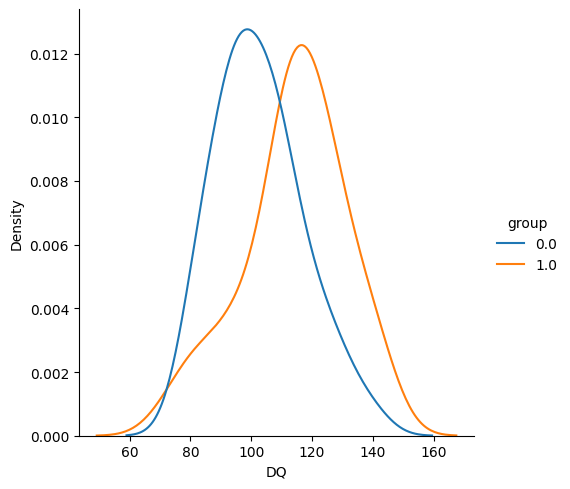

In [15]:


n = 100
group = [*np.zeros(n//2), *np.ones(n//2)]
DQ = (
    100 # intercept
    + group * stats.halfnorm.rvs(10, size=n)
    + stats.norm.rvs(0, 15, size=n) # error (sigma of the dist)
)
df = pd.DataFrame({
    'id': range(n),
    'group': group,
    'DQ': DQ,
})

sns.displot(df, x='DQ', hue='group', kind='kde');



## Exploración e inferencia convencional

In [16]:
g1 = df.query('group == 1')['DQ']
g0 = df.query('group == 0')['DQ']

ttp = stats.ttest_ind(g1, g0).pvalue

def pooled_sd(g1, g0):
    df1 = len(g1) - 1
    df0 = len(g0) - 1
    var1 = np.var(g1, ddof=1)
    var0 = np.var(g0, ddof=1)
    p_var = (df1*var1 + df0*var0) / (df1 + df0)
    return np.sqrt(p_var)


mean_diff = g1.mean() - g0.mean()
d = (mean_diff) / pooled_sd(g1, g0)
print(f'Mean difference: {mean_diff:.4f}| p={ttp:.4f} | {d=:.4f}')

Mean difference: 11.5380| p=0.0003 | d=0.7418


In [20]:
with pm.Model() as model:
    group = pm.Data('group', df['group'].values)
    pop_mu = pm.Normal('pop_mu', 100, 5)
    sigma = pm.HalfNormal('sigma', sigma=15, shape=2)
    eff = pm.Normal('eff', mu=5, sigma=10)
    mu = pm.Deterministic('mu', pop_mu + group * eff)
    iq = pm.Normal('IQ', mu=mu, sigma=sigma[df['group'].astype(int).values], observed=df['X'])
    idata = pm.sample(nuts_sampler='nutpie', progressbar=0)
    pm.sample_posterior_predictive(idata, progressbar=0, extend_inferencedata=True,)

post = idata.posterior
s0 = post['sigma'].sel(sigma_dim_0=0)
s1 = post['sigma'].sel(sigma_dim_0=1)

pooled_sigma = np.sqrt((s0**2 + s1**2) / 2)
idata.posterior['cohens_d'] = post['eff'] / pooled_sigma
idata.posterior['glass_delta'] = post['eff'] / s0

az.summary(idata, var_names=['cohens_d', 'glass_delta'])

Sampling: [IQ]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cohens_d,0.855,0.194,0.506,1.227,0.004,0.003,2128.0,2703.0,1.0
glass_delta,0.839,0.200,0.470,1.211,0.004,0.003,2322.0,2752.0,1.0


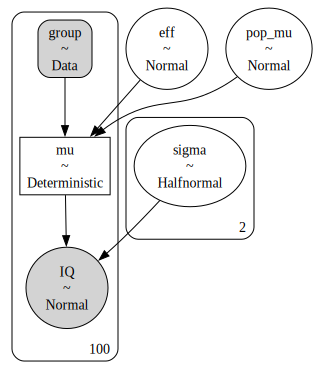

In [ ]:
model.to_graphviz()

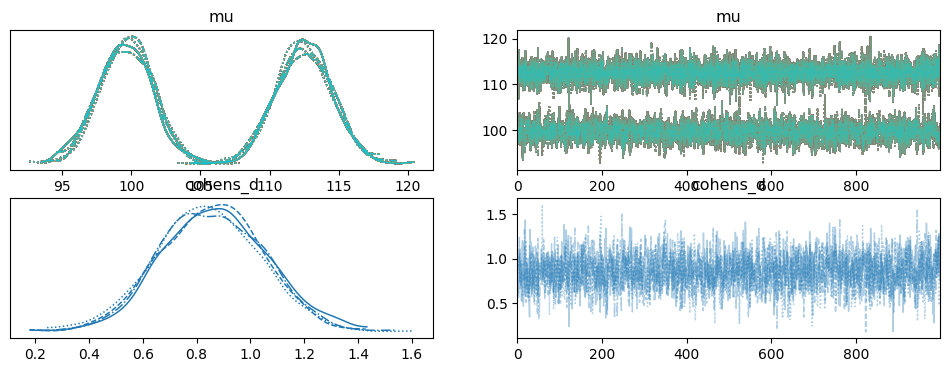

In [21]:
az.plot_trace(idata, var_names=['mu', 'cohens_d']);

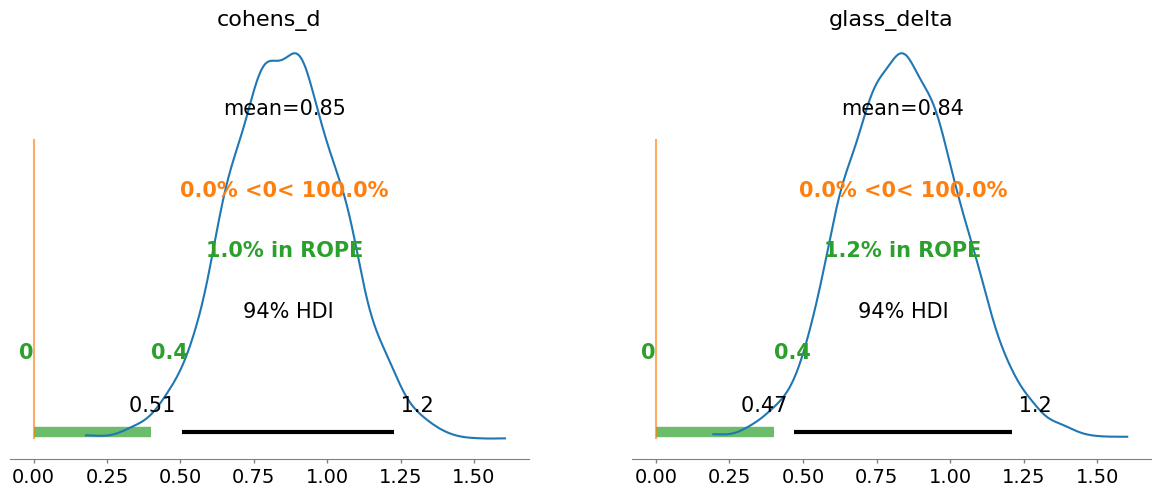

In [22]:
az.plot_posterior(idata, var_names=['cohens_d', 'glass_delta'], ref_val=0, rope=[0, 0.4]);

In [19]:
with pm.Model() as model:
    group = pm.Data('group', df['group'].values)
    pop_mu = pm.Normal('pop_mu', 100, 5)
    sigma = pm.HalfNormal('sigma', sigma=15, shape=2)
    eff = pm.Normal('eff', mu=5, sigma=10)
    mu = pm.Deterministic('mu', pop_mu + group * eff)
    dq = pm.Normal('DQ', mu=mu, sigma=sigma[df['group'].astype(int).values], observed=df['DQ'])
    idata = pm.sample(nuts_sampler='nutpie', progressbar=0)
    pm.sample_posterior_predictive(idata, progressbar=0, extend_inferencedata=True,)

post = idata.posterior
s0 = post['sigma'].sel(sigma_dim_0=0)
s1 = post['sigma'].sel(sigma_dim_0=1)

pooled_sigma = np.sqrt((s0**2 + s1**2) / 2)
idata.posterior['cohens_d'] = post['eff'] / pooled_sigma
idata.posterior['glass_delta'] = post['eff'] / s0

az.summary(idata, var_names=['cohens_d', 'glass_delta'])

KeyError: 'DQ'

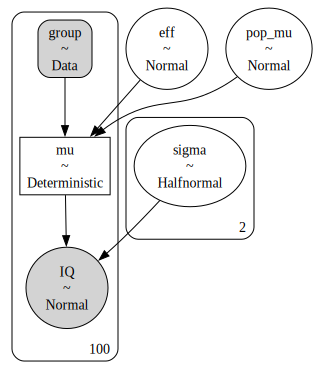

In [191]:
model.to_graphviz()

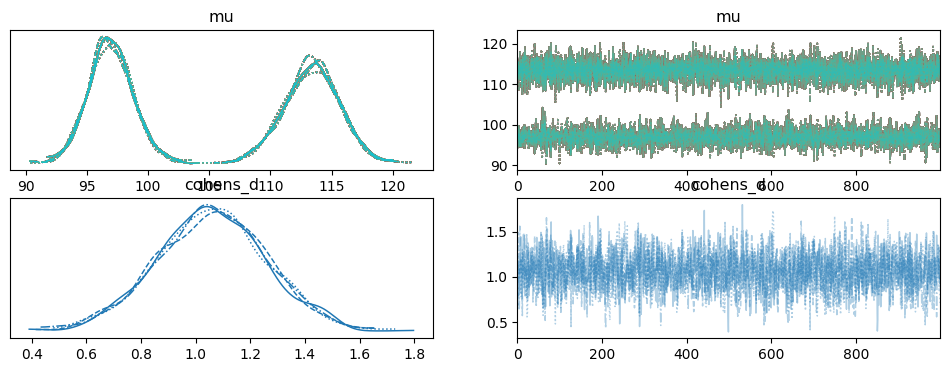

In [177]:
az.plot_trace(idata, var_names=['mu', 'cohens_d']);

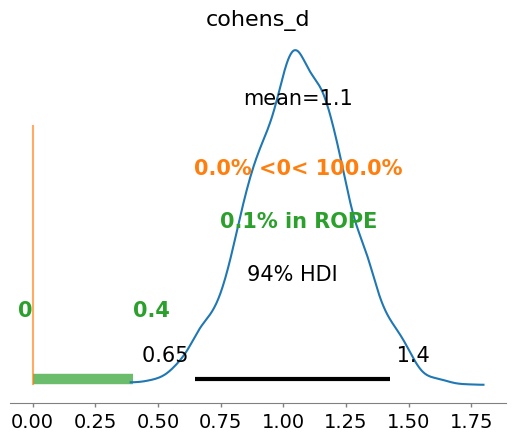

In [178]:
az.plot_posterior(idata, var_names='cohens_d', ref_val=0, rope=[0, 0.4]);

<Axes: xlabel='IQ'>

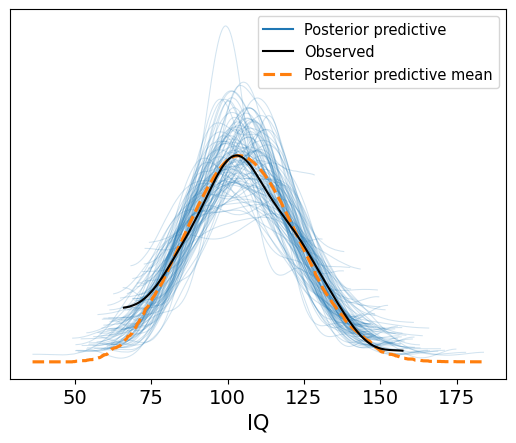

In [179]:
az.plot_ppc(idata, num_pp_samples=100)

51


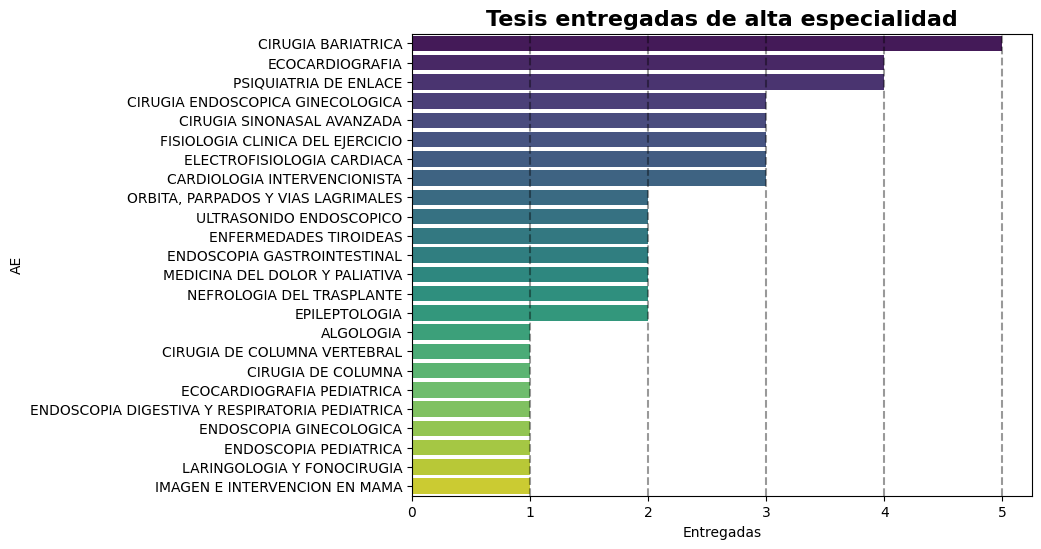

In [100]:
data = """Endoscopia gastrointestinal
Imagen e Intervención en mama
Fisiología Clínica del Ejercicio
Fisiología clínica del ejercicio
Fisiología clínica del ejercicio
Electrofisiologia Cardiaca
Ecocardiografía Adultos
Alta Especialidad en Enfermedades Tiroideas
Cirugía Bariátrica
Algología
Ecocardiografía
Electrofisiología cardíaca
Electrofisiología Cardíaca
Cirugía de Columna Vertebral
Cirugía Bariátrica
Ecocardiografía Adultos
Ecocardiografía
Cirugía endoscopica ginecologica
Cirugía Endoscópica Ginecológica
Nefrología del Trasplante
Endoscopia ginecologica
Psiquiatría de enlace
Psiquiatria de enlace
Cirugía bariátrica
Cirugía endoscópica Ginecologica
Ecocardiografía Pediátrica
Enfermedades Tiroideas
Cirugía de columna
Cardiologia Intervencionista
Epileptología
MEDICINA DEL DOLOR Y PALIATIVA
Medicina del Dolor y Paliativa
Epileptología
Nefrología del Trasplante
Cardiología Intervencionista
Psiquiatría de enlace
Ultrasonido endoscópico
Endoscopia Gastrointestinal
Endoscopia Pediátrica
Endoscopía digestiva y respiratoria pediátrica
Cirugía Sinonasal Avanzada
Laringología y Fonocirugía
Cirugía Sinonasal Avanzada
Cirugía Sinonasal Avanzada
Orbita, párpados y vías lagrimales
Ultrasonido endoscopico
Cardiologia Intervencionista
Órbita, párpados y vías lagrimales
Cirugía Bariátrica
Psiquiatria de Enlace
Cirugía Bariátrica"""
import numpy as np
import pandas as pd
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt

def remove_accents(text):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)
    )

data = pd.DataFrame(
    pd.Series(data.split('\n'), name='AE')
    .str.strip()
    .str.upper()
    .str.replace(' ADULTOS', '')
    .str.replace('ALTA ESPECIALIDAD EN ', '')
    .map(remove_accents)
    .sort_values()
)
order  = data['AE'].value_counts()
plt.figure(figsize=(8, 6))
sns.countplot(
    data, 
    y='AE', 
    hue='AE', 
    order=order.index,
    hue_order=order.index,
    palette='viridis',
)
for c in order.unique():
    plt.axvline(c, c='k', ls='--', alpha=0.4)

plt.title("Tesis entregadas de alta especialidad", fontsize=16, weight="bold")
plt.xlabel("Entregadas")
print(len(data['AE']))

In [145]:
stats.halfnorm.rvs(scale=10, size=5)

array([ 3.29680176,  5.05191504, 14.8696841 ,  7.45067678, 10.71827813])